# MEGI001-2101033 Introduction to Earth System Data

## Task 5.3 - Data Handling Analysis

Created on: Jan 24, 2019 by Ralph Florent <r.florent@jacobs-university.de>

## T 5.3 : Spectral analysis

Please perform the operations above (in a new notebook, properly renamed) for the labotory spectrum of Montmorillonite, i.e. ```montmorillonite-1292F35-RELAB.txt```.

Please document any isssue/trouble

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Jan 24 2019

@author: Angelo Rossi, Ralph Florent
"""
# Import relevant libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd # we'll use pandas to load data
from scipy.interpolate import interp1d

# We'll be looking at phylosiclicates (clays), as they have a fairly complex spectra with many features:
# In the data_samples folder we have two spectra for Montmorillonite
PATH = '../assets/data/spectral_data/'
specSlPhyMontm = pd.read_csv(PATH + 'FRTC596_537-220-5x5_Al-phyllo_montm.txt', skipinitialspace=True, sep=' ',
                    skiprows=3, header=None)

relabMontm = pd.read_csv(PATH + 'montmorillonite-1292F35-RELAB.txt', skipinitialspace=True, sep=' ',
                      skiprows=3, header=None)
# also we have two spectra for Nontronite
specFePhyNontr = pd.read_csv(PATH + 'FRTC596_537-220-5x5_Fe-phyllo_nontr.txt', skipinitialspace=True, sep=' ',
                         skiprows=3, header=None)

relabNontr = pd.read_csv(PATH + 'nontronite-CBJB26-RELAB.txt', skipinitialspace=True, sep=' ',
                         skiprows=3, header=None)

specFePhyNontr[:5] # take a look at what our data looks like

,0,1
0,1.00135,1.000000
1,1.00790,1.000000
2,1.01445,1.164158
3,1.02100,1.159755
4,1.02755,1.169514


In [2]:
# rename columns using dictionary
specFePhyNontr.rename(columns={0:'wavelength',1:'specFePhyNontr'})[:5]

,wavelength,specFePhyNontr
0,1.00135,1.000000
1,1.00790,1.000000
2,1.01445,1.164158
3,1.02100,1.159755
4,1.02755,1.169514


In [3]:
# This worked, lets fix all dataframes now:
specSlPhyMontm = specSlPhyMontm.rename(columns={0:'wavelength',1:'specSlPhyMontm'})
relabMontm     = relabMontm.rename(columns={0:'wavelength',1:'relabMontm'})
specFePhyNontr = specFePhyNontr.rename(columns={0:'wavelength',1:'specFePhyNontr'})
relabNontr     = relabNontr.rename(columns={0:'wavelength',1:'relabNontr'})

In [4]:
#lets check:
relabNontr[:5]

,wavelength,relabNontr
0,0.3500,0.0324
1,0.3525,0.0340
2,0.3550,0.0356
3,0.3575,0.0368
4,0.3600,0.0380


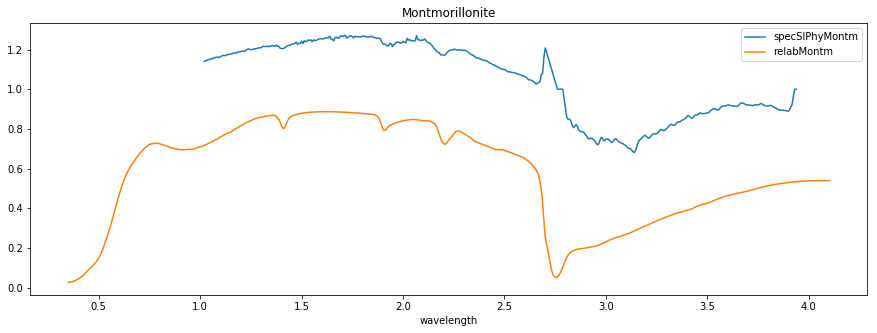

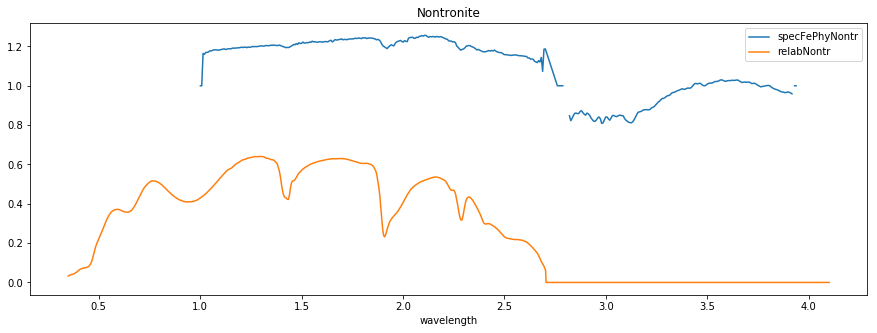

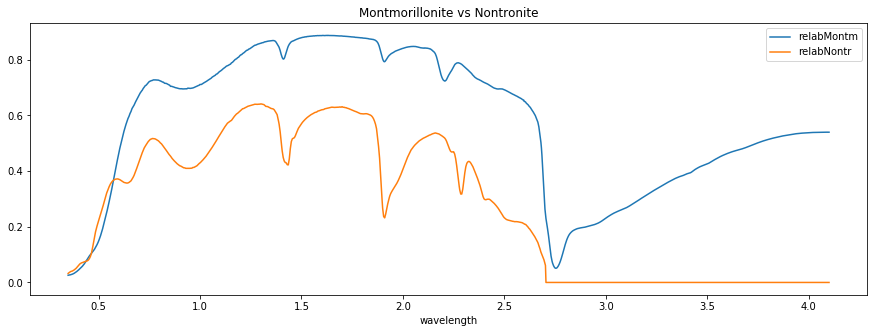

In [5]:
#lets plot:
ax1 = specSlPhyMontm.plot.line(0, figsize=(15,5), title="Montmorillonite")
relabMontm.plot.line(0, ax=ax1) # ax=ax plots all on the same axis

ax2 = specFePhyNontr.plot.line(0, figsize=(15,5), title="Nontronite")
relabNontr.plot.line(0, ax=ax2)

ax3 = relabMontm.plot.line(0, figsize=(15,5), title="Montmorillonite vs Nontronite")
relabNontr.plot.line(0, ax=ax3)

plt.show()

## Continuum removal
When processing reflective spectrometry, we normally want to look at absorption features.

Remember that this is a plot of reflectivity against wavelength, the higher absorption means lower reflection,
so what we want to find are location of "troughs", ie local minima.

The first step we could do towards solving this non-trivial problem would be to remove continuum, or the shape of the spectra "at large" then the troughs would become more aparent and easier to identify.

For this example we shall use the *relabNontr* spectra, as it is the smoothest and would be easiest to show the process in an ideal case.

In this part of the tutorial we will show how not only how to apply code, but also how to write it, thus demonstrating the entire workflow of ad-hoc data analysis.

We begin by creating simple fake datasets to test our code while we're writing it, gradually increasing complexity
while develping code, and lastly applying it to real data.

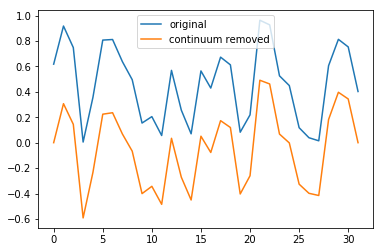

In [7]:
#lets put this into a function so we can reuse it later:
def removeCont(pSample):
    pSampleLineX=[pSample[0][0],pSample[0][-1]]
    pSampleLineY=[pSample[1][0],pSample[1][-1]]
    pSampleLine=[pSampleLineX,pSampleLineY]
    finterp = interp1d(pSampleLine[0],pSampleLine[1])#create interploation function
    return pSample[1]-finterp(pSample[0])

# Lets try this on a bigger fake dataset:
pivot = lambda sample: [[a[0] for a in sample],[a[1] for a in sample]]

sample = np.asarray([list(x) for x in zip(range(32),[x[0] for x in np.random.random((32,1)).tolist()])])
pSample=pivot(sample)
plt.plot(pSample[0],pSample[1], '-',pSample[0],removeCont(pSample),'-')
plt.legend(['original', 'continuum removed'], loc='best')
plt.show()

In [8]:
#we can now easily find a maximum value above the continuum for points other than first and last:
max(removeCont(pSample)[1:-1])

0.4910701772225

In [11]:
#furthermore, we can ask numpy for an index of max:
maxIndex = np.argmax(removeCont(pSample)[1:-1]) +1
maxIndex

21

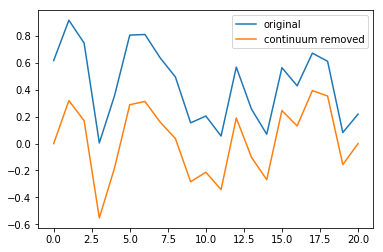

In [12]:
#Armed with this information we can repeat the previous step for a subset:
plt.plot(pSample[0][:maxIndex],pSample[1][:maxIndex], '-',pSample[0][:maxIndex],
         removeCont([pSample[0][:maxIndex],pSample[1][:maxIndex]]),'-')
plt.legend(['original', 'continuum removed'], loc='best')
plt.show()

In [13]:
# From henceforth we could do this recursively - that is to use the output of a function as an input to itself:
def getMaxima(pSample):
    def getMaximaInner(innerSample):
        contRem=removeCont(innerSample)
        #print(contRem)
        maxIndex=np.argmax(contRem)
        #print(maxIndex)
        maxVal=contRem[maxIndex]
        maxLoc=innerSample[0][maxIndex]
        if len(contRem)>2 and maxVal>contRem[0] and maxVal>contRem[-1]: # check that the maximum is more than edges
            maxLocArray.append(maxLoc)
            #print(maxLoc)
            subsetLeft=[innerSample[0][:maxIndex+1],innerSample[1][:maxIndex+1]]
            #print(subsetLeft[0])
            subsetRight=[innerSample[0][maxIndex:],innerSample[1][maxIndex:]]
            #print(subsetRight[0])
            getMaximaInner(subsetLeft)
            getMaximaInner(subsetRight)
    maxLocArray=[] #initialize array to store a list of points on a convex hull
    getMaximaInner(pSample)
    maxLocArray.sort()
    return [pSample[0][0]]+maxLocArray+[pSample[0][-1]]

#maxList=getMaxima([pSample[0][:5],pSample[1][:5]])
maxList=getMaxima(pSample)
print(maxList)

[0.0, 1.0, 21.0, 29.0, 30.0, 31.0]


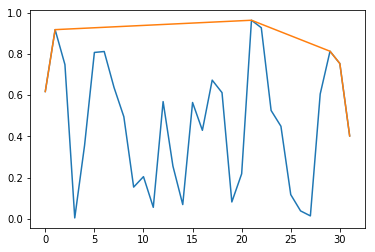

In [14]:
hull=[maxList,[x[1] for x in sample if x[0] in maxList]]
plt.plot(pSample[0],pSample[1], '-',hull[0],hull[1],'-')
plt.show()

[0.35, 0.645, 0.655, 0.665, 0.7, 0.7025, 0.705, 0.71, 0.72, 0.73, 0.75, 0.7525, 0.755, 0.7575, 0.76, 0.77, 1.28501, 1.31751, 1.33251, 1.33501, 1.35001, 1.35251, 1.5275100000000001, 1.54251, 1.5600100000000001, 1.57751, 1.60501, 1.63001, 1.6500099999999998, 1.69502, 1.72002, 1.7600200000000001, 1.79752, 1.82002, 1.8525200000000002, 2.1175200000000003, 2.1250299999999998, 4.10007]


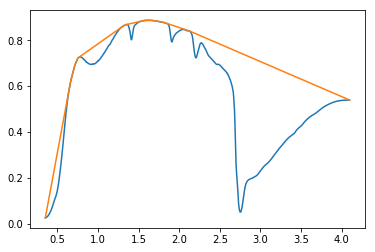

In [28]:
#Now lets try it with a real dataset:
sample = np.asarray(relabMontm)
pSample = pivot(sample)
maxList = getMaxima(pSample)
print(maxList)
hull = [maxList,[x[1] for x in sample if x[0] in maxList]]
plt.plot(pSample[0],pSample[1], '-',hull[0],hull[1],'-')

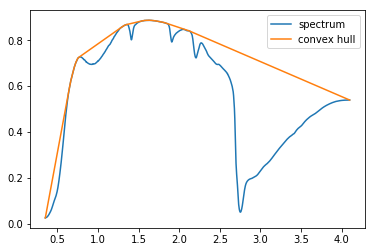

In [29]:
# You may notice that the formation of a convex hull is distorted 
# by a long row of zeros at the end of the data sample
# Lets remove all zeros:
cleanSample=[value for value in sample if value[1]>0]
pSample=pivot(cleanSample)
maxList=getMaxima(pSample)
#print(maxList)
pHull=[maxList,[x[1] for x in sample if x[0] in maxList]]
plt.plot(pSample[0],pSample[1], '-',pHull[0],pHull[1],'-')
plt.legend(['spectrum', 'convex hull'])
plt.show()

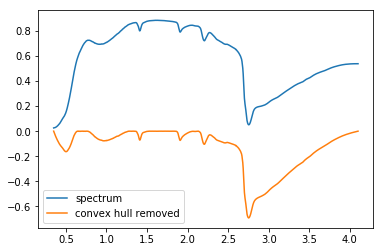

In [30]:
# Next we can subtact the convex hull from our data, in a manner similar to how we subtracted continuum ealier
def removeHull(pSample,pHull):
    finterp = interp1d(pHull[0],pHull[1])#create interploation function
    return pSample[1]-finterp(pSample[0])

hullRemoved = removeHull(pSample,pHull)
plt.plot(pSample[0],pSample[1],'-',pSample[0],hullRemoved, '-')
plt.legend(['spectrum', 'convex hull removed'])
plt.show()

In [31]:
# we can easily find indices for these values:
splitInd=[pSample[0].index(x) for x in pHull[0]]
print(splitInd)

[0, 118, 122, 126, 140, 141, 142, 144, 148, 152, 160, 161, 162, 163, 164, 168, 374, 387, 393, 394, 400, 401, 471, 477, 484, 491, 502, 512, 520, 538, 548, 564, 579, 588, 601, 707, 710, 1500]


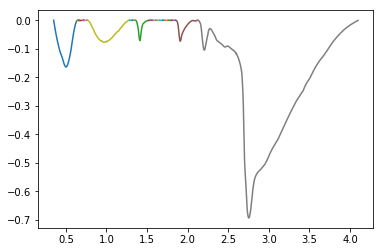

In [32]:
#then we can split the array along the indices using list comprehension:
splitSample=[[pSample[0][splitInd[i]:splitInd[i+1]],hullRemoved[splitInd[i]:splitInd[i+1]]] 
             for i in range(len(splitInd)-1) if splitInd[i+1]-splitInd[i]>2]
for s in splitSample:
    plt.plot(s[0],s[1],'-')
plt.show()

In [33]:
# Finding local minima is then straightforward:
listMinimaX=[x[0][np.argmin(x[1])] for x in np.asarray(splitSample)]
print(listMinimaX)

[0.5, 0.65, 0.66, 0.675, 0.715, 0.725, 0.735, 0.765, 0.9649989999999999, 1.31251, 1.3200100000000001, 1.34251, 1.41251, 1.53251, 1.55001, 1.56251, 1.60001, 1.61501, 1.63501, 1.6875200000000001, 1.7075200000000001, 1.74752, 1.7925200000000001, 1.8025200000000001, 1.8325200000000001, 1.90752, 2.12252, 2.75254]


In [34]:
# we can use list comprehension again to get corresponding Y-values
listMinimaY=[pSample[1][pSample[0].index(x)] for x in listMinimaX]
print(listMinimaY)

[0.147886, 0.5962310000000001, 0.613917, 0.6364529999999999, 0.68966, 0.700813, 0.708335, 0.7251489999999999, 0.6981930000000001, 0.8612120000000001, 0.863458, 0.8668040000000001, 0.8020229999999999, 0.882941, 0.8839969999999999, 0.884804, 0.8861610000000001, 0.886151, 0.8864700000000001, 0.884685, 0.8839049999999999, 0.881386, 0.8780020000000001, 0.877296, 0.874332, 0.792406, 0.8403290000000001, 0.050927999999999994]


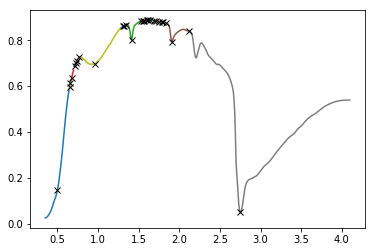

In [35]:
#And we can combine the two and plot the minima on a graph:
splitSample=[[pSample[0][splitInd[i]:splitInd[i+1]],pSample[1][splitInd[i]:splitInd[i+1]]] 
             for i in range(len(splitInd)-1) if splitInd[i+1]-splitInd[i]>2]
for s in splitSample:
    plt.plot(s[0],s[1],'-')
plt.plot(listMinimaX,listMinimaY,'x',color='black')
plt.show()

In [36]:
# We've now identified some deep absorption bands, a some shallow that are probably noise.
# We can filter out the shallow ones by appling a threshold:
# First get the band depths with hull removed:
listMinimaYhullRemoved=[hullRemoved[pSample[0].index(x)] for x in listMinimaX]
print(listMinimaYhullRemoved)

[-0.164038593220339, -0.0012439999999999118, -0.0014969999999999706, -0.0018607142857144376, -0.001191499999999901, -0.00041949999999990606, -0.0016217499999999774, -0.0006010000000000737, -0.0775282730374166, -0.0008936923076922065, -0.00026533333333345066, -0.00030749999999990507, -0.07128997142857141, -0.00025966666666665805, -0.0005232857142857261, -0.0005748571428570992, -0.0004524545454545059, -0.0006745999999999697, -0.00045824999999988236, -0.0006101055321039439, -0.00036400000000003097, -0.0003699374999999172, -0.0007395333333332088, -0.0006458888888889458, -0.0005426153846154191, -0.07365320754716964, -0.0003079134487349311, -0.6937509342696857]


In [37]:
# Now apply a threshold:
threshold=0.05
listMinimaSigX=[q[0] for q in list(zip(listMinimaX,listMinimaYhullRemoved)) if q[1]<-threshold]
listMinimaSigYhullRemoved=[q[1] for q in list(zip(listMinimaX,listMinimaYhullRemoved)) if q[1]<-threshold]
listMinimaSigY=[pSample[1][pSample[0].index(x)] for x in listMinimaSigX]

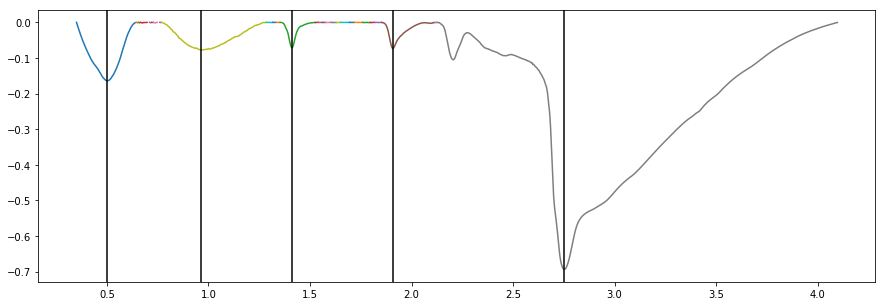

In [38]:
#then we can split the array along the indices using list comprehension:
splitSample=[[pSample[0][splitInd[i]:splitInd[i+1]],hullRemoved[splitInd[i]:splitInd[i+1]]] 
             for i in range(len(splitInd)-1) if splitInd[i+1]-splitInd[i]>2]
plt.figure(figsize=(15,5)) #make larger figure
for s in splitSample:
    plt.plot(s[0],s[1],'-')
for xc in listMinimaSigX:
    plt.axvline(x=xc,color='black')
plt.show()

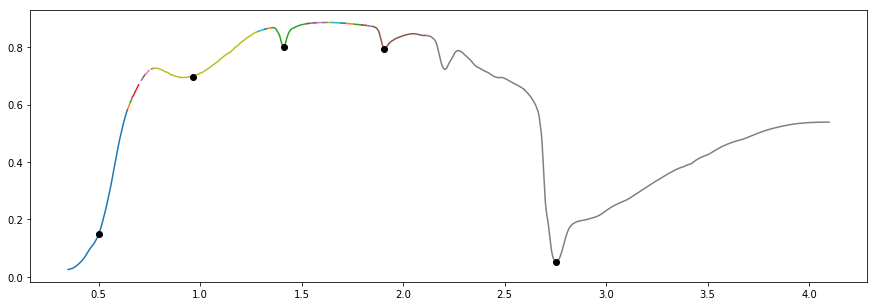

In [39]:
# Finally, lets see where do these band depths plot on original spectra:
plt.figure(figsize=(15,5))
splitSample=[[pSample[0][splitInd[i]:splitInd[i+1]],pSample[1][splitInd[i]:splitInd[i+1]]] 
             for i in range(len(splitInd)-1) if splitInd[i+1]-splitInd[i]>2]
for s in splitSample:
    plt.plot(s[0],s[1],'-')
plt.plot(listMinimaSigX,listMinimaSigY,'o',color='black')
plt.show()

In [40]:
print("adsorption band center wavelenghts are:")
for item in listMinimaSigX:
    print(item, "micrometers")

adsorption band center wavelenghts are:
0.5 micrometers
0.9649989999999999 micrometers
1.41251 micrometers
1.90752 micrometers
2.75254 micrometers
